# Imports

In [1]:
import torch
import gpytorch
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

from ipywidgets import interact
import glob
import numpy as np
from helper import open_img_as_array
from skimage.measure import label

PATH_TO_DATA = './CloC/'

IMG_SIZE = (50, 100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Helper functions

In [2]:
def map_to_cylinder(points):
    return torch.stack((torch.cos(2 * torch.pi * points[:, 1]), torch.sin(2 * torch.pi * points[:, 1]), torch.pi * points[:, 0]), -1)

def clear_small_groups(img, min_size=100):
    img = img.copy()
    cimg = img.copy()
    cimg[img < img.max()] = 0
    cimg[img == img.max()] = 1
    limg = label(cimg, background=1)
    unique, counts = np.unique(limg, return_counts=True)
    for i, count in zip(unique, counts):
        if count < min_size:
            img[limg == i] = 0
    return img

# GPModel class

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, RBF_lengthscale_constraint=None, Periodic_lengthscale_constraint=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ZeroMean()
        self.RBF = gpytorch.kernels.RBFKernel(
            ard_num_dims=3, lengthscale_constraint=RBF_lengthscale_constraint)
        self.Periodic = gpytorch.kernels.PeriodicKernel(
            ard_num_dims=3, lengthscale_constraint=Periodic_lengthscale_constraint)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            self.RBF) + gpytorch.kernels.ScaleKernel(self.Periodic)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def start_training(self, train_x, train_y, num_iter=100, need_plot=True):
        self.train()
        self.likelihood.train()
        # Includes GaussianLikelihood parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        my_loss = gpytorch.mlls.ExactMarginalLogLikelihood(
            self.likelihood, self)

        history = {"loss": [],
                   "lengthscale": [],
                   "noise": []}

        for _ in tqdm(range(num_iter), desc='Training'):
            optimizer.zero_grad()
            output = self(train_x)
            loss = -my_loss(output, train_y)
            loss.backward()
            history["loss"].append(loss.item())
            # lengthscale = self.covar_module.base_kernel.lengthscale.item()
            # history["lengthscale"].append(lengthscale)
            # history["noise"].append(self.likelihood.noise.item())
            optimizer.step()

        if need_plot:
            plt.figure(figsize=(10, 5))
            plt.plot(history["loss"])
            plt.title(f'Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()

    def predict(self, data, num_samples=16, need_plot=True):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            sampled_preds = self(data.to(device)).rsample(
                sample_shape=torch.Size((num_samples,)))

        if need_plot:
            n = int(num_samples ** 0.5)
            _, axs = plt.subplots(n, n, figsize=(20, 10))
            plt.suptitle(f'Samples')
            for i in range(n):
                for j in range(n):
                    axs[i, j].imshow(
                        sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
                    axs[i, j].contour(
                        sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), levels=0, colors='k')
                    axs[i, j].axis('off')
            plt.show()

        return sampled_preds

# Generation of the dataset

In [4]:
def default_train():
    # Train set and test set initialization
    dx, dy = 1 / IMG_SIZE[0], 1 / IMG_SIZE[1]
    xv, yv = torch.meshgrid(torch.linspace(0, 1-dx, IMG_SIZE[0]), torch.linspace(0, 1-dy, IMG_SIZE[1]), indexing="ij")
    x_test = torch.cat((
        xv.contiguous().view(xv.numel(), 1),
        yv.contiguous().view(yv.numel(), 1)),
        dim=1)

    x_train = torch.cat((x_test[:5*IMG_SIZE[1], :], x_test[-5*IMG_SIZE[1]:, :]), 0)
    x_train = map_to_cylinder(x_train)
    x_test = map_to_cylinder(x_test)
    y_train = torch.cat((torch.ones(5*IMG_SIZE[1]), -torch.ones(5*IMG_SIZE[1])))

    # Model initialization and training
    rbf_lengthscale_right = Interval(0.01, 0.32)
    periodic_lengthscale_right = Interval(0.01, 0.15)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(x_train, y_train, likelihood, RBF_lengthscale_constraint=rbf_lengthscale_right, Periodic_lengthscale_constraint=periodic_lengthscale_right)

    model = model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    model.start_training(x_train, y_train, num_iter=100, need_plot=True)
    
    return model, x_test


## Sampling

### Prediction

Training: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


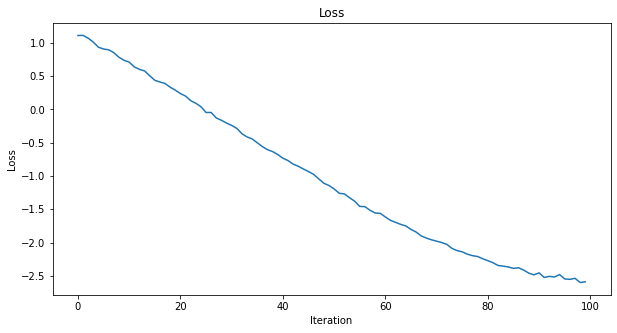

In [5]:
model, x_test = default_train()

In [6]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=False)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

### Saving results

In [ ]:
os.makedirs(PATH_TO_DATA, exist_ok=True)

for i, sample in enumerate(samples):
    plt.imshow(sample * 0, cmap='gray_r')
    plt.contour(sample, levels=0, colors='k')
    plt.axis('off')
    plt.savefig(PATH_TO_DATA + f'/{i+1:05}.png', bbox_inches='tight', pad_inches=0, facecolor='white')
    # don't display image
    # plt.clf()
    break


# Splitting, clearing and getting targets

In [7]:
def split_map(path, x_parts, scale_coef, color, p, need_plot=False):
    img = open_img_as_array(path) if isinstance(path, str) else path
    splitted = img.copy()
    imax = img.max()

    width, height = img.shape
    ratio = height / width

    sq_size = width // x_parts
    delta = int(scale_coef * sq_size / 2)
    
    # for x in range(sq_size // 2, width, sq_size):
    #     for y in range(sq_size // 2, height, sq_size):
    #         splitted[x-delta:x+delta, y-delta:y+delta] = color

    # the loop above colors the uniform squares with the same color
    # now i want to do the same but shift all squares by a random unit vector

    for x in range(sq_size // 2, width, sq_size):
        for y in range(sq_size // 2, height, sq_size): 
            # do the next with probability p:
            if np.random.rand() < p:
                shift = np.random.randint(-delta // 2, delta // 2, 2)
                splitted[x+shift[0]-delta:x+shift[0]+delta, y+shift[1]-delta:y+shift[1]+delta] = color

    # black_pixs = np.sum(splitted < imax)
    # cleared = clear_small_groups(splitted, min_size)
    # print(np.unique(cleared))
    # percent_of_cleared = 100 * (1 - np.sum(cleared < imax) / black_pixs)
    # print(f'percent_of_cleared = {percent_of_cleared:.2f}%')
    # if need_plot:
    #     plt.subplot(1, 3, 3)
    #     plt.imshow(cleared, cmap='gray')
    #     plt.title(f'After clearing {percent_of_cleared:.2f}% of black pixels')

    return splitted

In [ ]:
@interact(i=(0, len(samples) - 1), x_parts=(2, 10), scale_coef=(0.5, 1, 0.05), p=(0, 1, 0.1), color=(0, 1, 0.05))
def real_time(i=0, x_parts=5, scale_coef=0.85, p=0.5, color=0):
    img = samples[i]
    # normalize to [-1, 1]
    img = (img - img.min()) / (img.max() - img.min()) * 2 - 1
    # print(img.min(), img.max())
    # # img = (img - img.min()) / (img.max() - img.min()) * 255
    sign = img > 0
    # values of sign are True or False
    # for every True value if at least one of its neighbours is False then it is a border
    # find all borders and make a new array with the same shape as img where borders are True and others are False
    original = np.zeros_like(img)
    for x in range(1, img.shape[0]-1):
        for y in range(1, img.shape[1]-1):
            original[x, y] = sign[x, y] and (not sign[x-1, y] or not sign[x+1, y] or not sign[x, y-1] or not sign[x, y+1])
    splitted = 1 - split_map(path=original, x_parts=x_parts, scale_coef=scale_coef, color=color, p=p, need_plot=False)
    plt.figure(figsize=(20, 5))
    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(1 - original, cmap='gray')
    plt.title('Original')
    # sign distribution
    plt.subplot(1, 3, 2)
    plt.imshow(sign, cmap='gray')
    plt.title('Sign distribution')
    # split map
    plt.subplot(1, 3, 3)
    plt.imshow(splitted, cmap='gray')
    plt.title('Splitted')

# Downscaling

In [ ]:
def downscale_map(img, sq_size):
    img = np.array(img)
    width, height = img.shape
    x_parts = width // sq_size
    y_parts = height // sq_size
    downsampled = np.zeros((x_parts, y_parts))
    for x in range(x_parts):
        for y in range(y_parts):
            downsampled[x, y] = (img[x*sq_size:(x+1)*sq_size, y*sq_size:(y+1)*sq_size] < img.max()).sum == 0
    return downsampled

@interact(i=(0, len(samples)-1) , sq_size=(1, 25))
def _(i, sq_size=5):
    img = samples[i] > 0
    downsampled = downscale_map(img, sq_size)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original shape = {img.shape}')
    plt.subplot(1, 2, 2)
    plt.imshow(downsampled, cmap='gray')
    plt.title(f'Downsampled shape = {downsampled.shape}')
